## 2D Acoustic wave equation
---

[Here's the notebook](https://github.com/devitocodes/devito/blob/master/examples/seismic/tutorials/01_modelling.ipynb)

In [1]:
import devito
import sys
sys.path.append("../../devito/")

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

Operator `initdamp` run in 0.01 s
Operator `padfunc` run in 0.01 s


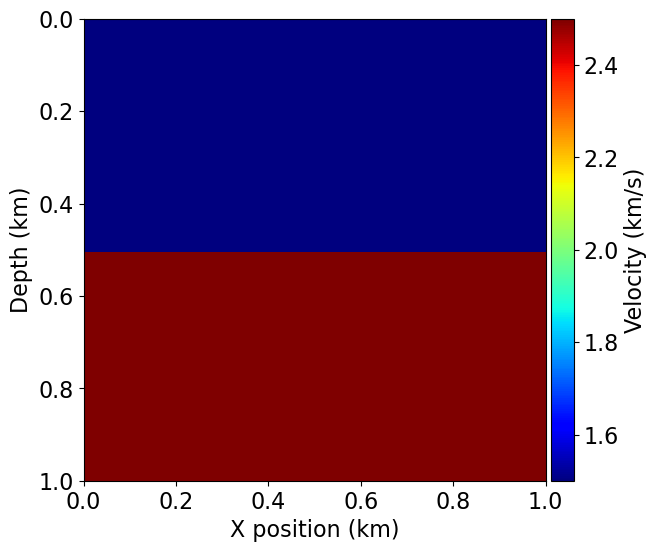

In [2]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import Model, plot_velocity

N = 101

# Define a physical size
shape = (N, N)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:, :51] = 1.5
v[:, 51:] = 2.5

# With the velocity and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 10 grid points
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=10, bcs="damp")

plot_velocity(model)

In [3]:
from examples.seismic import TimeAxis

t0 = 0.  # Simulation starts a t=0
tn = 1000.  # Simulation last 1 second (1000 ms)
dt = model.critical_dt  # Time step from model grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

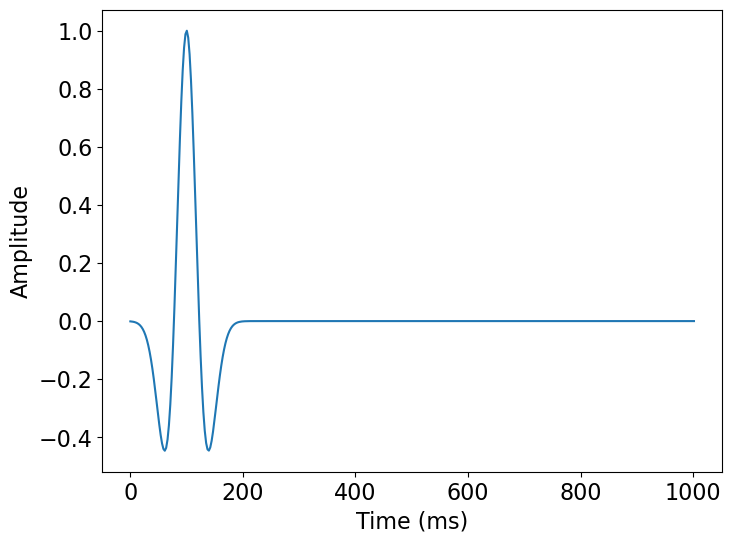

In [4]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import RickerSource

f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=1, time_range=time_range, nt = time_range.num)

# First, position source centrally in all dimensions, then set depth
src.coordinates.data[0, :] = np.array(model.domain_size) * .5
src.coordinates.data[0, -1] = 20.  # Depth is 20m

# We can plot the time signature to see the wavelet
src.show()

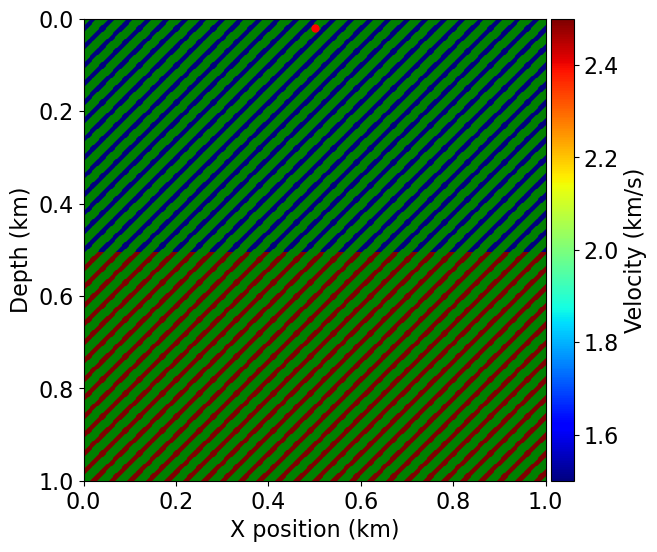

In [5]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import Receiver

# Create symbol for N receivers
N_point = N*N
rec = Receiver(name='rec', grid=model.grid, npoint=N_point, time_range=time_range, nt = time_range.num)

# Prescribe even spacing for receivers along the x-axis
for i in range(N):
	rec.coordinates.data[i*N:(i+1)*N, 0] = np.linspace(0, model.domain_size[0], num=N)
	rec.coordinates.data[i*N:(i+1)*N:, 1] = i*10.0  # Depth is 20m

# We can now show the source and receivers within our domain:
# Red dot: Source location
# Green dots: Receiver locations (every 4th point)
plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::4, :])

In [6]:
# In order to represent the wavefield u and the square slowness we need symbolic objects 
# corresponding to time-space-varying field (u, TimeFunction) and 
# space-varying field (m, Function)
from devito import TimeFunction

# Define the wavefield with the size of the model and the time dimension
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=2)

# We can now write the PDE
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt

# The PDE representation is as on paper
pde

damp(x, y)*Derivative(u(t, x, y), t) - Derivative(u(t, x, y), (x, 2)) - Derivative(u(t, x, y), (y, 2)) + Derivative(u(t, x, y), (t, 2))/vp(x, y)**2

In [7]:
# This discrete PDE can be solved in a time-marching way updating u(t+dt) from the previous time step
# Devito as a shortcut for u(t+dt) which is u.forward. We can then rewrite the PDE as 
# a time marching updating equation known as a stencil using customized SymPy functions
from devito import Eq, solve

stencil = Eq(u.forward, solve(pde, u.forward))

In [8]:
# Finally we define the source injection and receiver read function to generate the corresponding code
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)

# Create interpolation expression for receivers
rec_term = rec.interpolate(expr=u.forward)

In [9]:
#NBVAL_IGNORE_OUTPUT
from devito import Operator

op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)

In [10]:
#NBVAL_IGNORE_OUTPUT
op(time=time_range.num-1, dt=model.critical_dt)

Operator `Kernel` run in 0.06 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.0030840000000000177, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=2.1000000000000006e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.050626000000000185, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

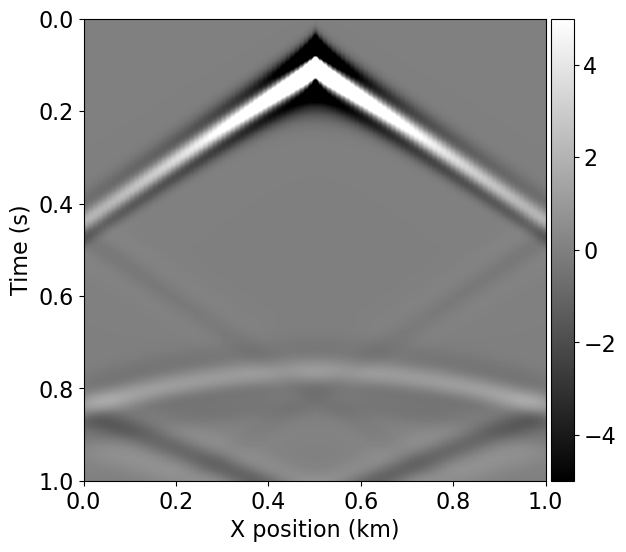

In [11]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_shotrecord

plot_shotrecord(rec.data[:, 2*N:3*N], model, t0, tn)

In [12]:
t = time_range.time_values
t_index = np.where(t > 200)[0]
t = t[t_index] / 500

p = rec.data[t_index, :]
x = np.linspace(0, model.domain_size[0], num=N) / 500 - 1.0
z = np.linspace(0, model.domain_size[1], num=N) / 500 - 1.0

import pickle
with open("dataset_single_source.pkl", "wb") as file:
	pickle.dump(list(map(lambda x: np.array(x), [x, z, t, p])), file)

In [13]:
z

array([-1.  , -0.98, -0.96, -0.94, -0.92, -0.9 , -0.88, -0.86, -0.84,
       -0.82, -0.8 , -0.78, -0.76, -0.74, -0.72, -0.7 , -0.68, -0.66,
       -0.64, -0.62, -0.6 , -0.58, -0.56, -0.54, -0.52, -0.5 , -0.48,
       -0.46, -0.44, -0.42, -0.4 , -0.38, -0.36, -0.34, -0.32, -0.3 ,
       -0.28, -0.26, -0.24, -0.22, -0.2 , -0.18, -0.16, -0.14, -0.12,
       -0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,  0.04,  0.06,
        0.08,  0.1 ,  0.12,  0.14,  0.16,  0.18,  0.2 ,  0.22,  0.24,
        0.26,  0.28,  0.3 ,  0.32,  0.34,  0.36,  0.38,  0.4 ,  0.42,
        0.44,  0.46,  0.48,  0.5 ,  0.52,  0.54,  0.56,  0.58,  0.6 ,
        0.62,  0.64,  0.66,  0.68,  0.7 ,  0.72,  0.74,  0.76,  0.78,
        0.8 ,  0.82,  0.84,  0.86,  0.88,  0.9 ,  0.92,  0.94,  0.96,
        0.98,  1.  ])

In [14]:
rec.coordinates.data

Data([[   0.,    0.],
      [  10.,    0.],
      [  20.,    0.],
      ...,
      [ 980., 1000.],
      [ 990., 1000.],
      [1000., 1000.]], dtype=float32)

In [16]:
rec.data.shape

(410, 10201)